In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.fft import rfft,rfftfreq,irfft
import requests

sns.set()

In [2]:
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/ManadFoddDod'
json_post = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Manad",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000000NF"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [3]:
r = requests.post(url,json = json_post)
r.status_code

200

In [4]:
json = r.json()
data = json['data']

In [5]:
dead_df = pd.DataFrame.from_dict(data)
dead_df

,key,values
0,"[1, 01, 1851]",[3245]
1,"[1, 01, 1852]",[3403]
2,"[1, 01, 1853]",[3559]
3,"[1, 01, 1854]",[2980]
4,"[1, 01, 1855]",[3244]
...,...,...
4051,"[2, 12, 2015]",[4080]
4052,"[2, 12, 2016]",[4379]
4053,"[2, 12, 2017]",[4228]
4054,"[2, 12, 2018]",[4091]


In [6]:
dead_df[['gender','month','year']] = dead_df['key'].to_list()
dead_df['dead'] = dead_df['values'].apply(lambda x : x[0])
dead_df.drop(['key','values'],axis=1,inplace=True)
dead_df['dead'] = dead_df['dead'].astype(int)
dead_df = dead_df.groupby(['year','month']).sum()
dead_df

dead
year month      
1851 01     6261
     02     6007
     03     8812
     04     7818
     05     7406
...          ...
2019 08     7031
     09     6855
     10     7536
     11     7438
     12     7896

[2028 rows x 1 columns]

In [7]:
dead_df = dead_df.loc['2015':'2019']
dead_df

dead
year month      
2015 01     8665
     02     8092
     03     8666
     04     7731
     05     7351
     06     6846
     07     7120
     08     6814
     09     7006
     10     7239
     11     7343
     12     7943
2016 01     8689
     02     7811
     03     8163
     04     7545
     05     7134
     06     6703
     07     7231
     08     7157
     09     6871
     10     7484
     11     7550
     12     8458
2017 01     9282
     02     8025
     03     8248
     04     7731
     05     7488
     06     6837
     07     6927
     08     6996
     09     6913
     10     7587
     11     7482
     12     8259
2018 01     8803
     02     8337
     03     9437
     04     7797
     05     6953
     06     6663
     07     7468
     08     6971
     09     6952
     10     7440
     11     7102
     12     8014
2019 01     8372
     02     7487
     03     7791
     04     7373
     05     7147
     06     6634
     07     6944
     08     7031
     09     6855
     10     7536
     11     7438
     12     7896

In [8]:
# deaths with unknown date not included # 
dead_df.groupby('year').sum()
start_year = dead_df.index[0][0]
end_year = dead_df.index[-1][0]
end_year

'2019'

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


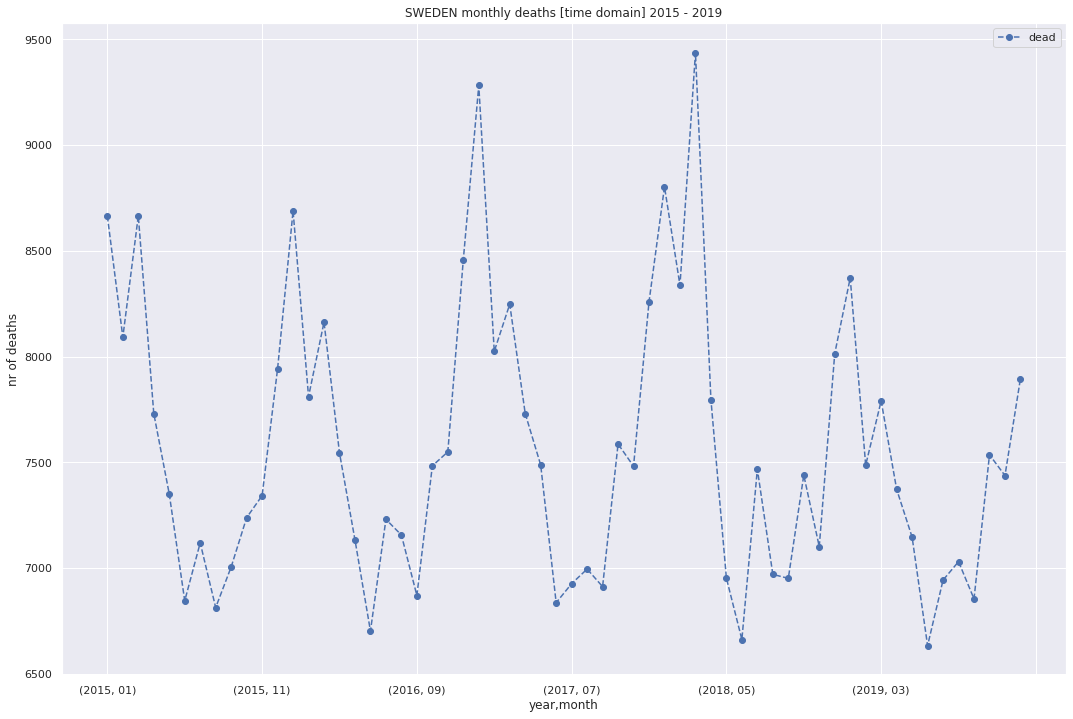

In [9]:
title = 'SWEDEN monthly deaths [time domain] {} - {}'.format(start_year,end_year)
dead_df.plot(figsize=(18,12),style='o--',title=title)
plt.ylabel('nr of deaths')
plt.savefig('swe_fft_time_domain_deaths_{}_{}.jpg'.format(start_year,end_year),format='jpg')

In [13]:
sample_rate = 12 # monthly data : set unit a year

signal = dead_df['dead']
signal = signal - signal.mean()
signal = signal.values

yf = rfft(signal) 

xf = rfftfreq(len(signal),1 / sample_rate)


5


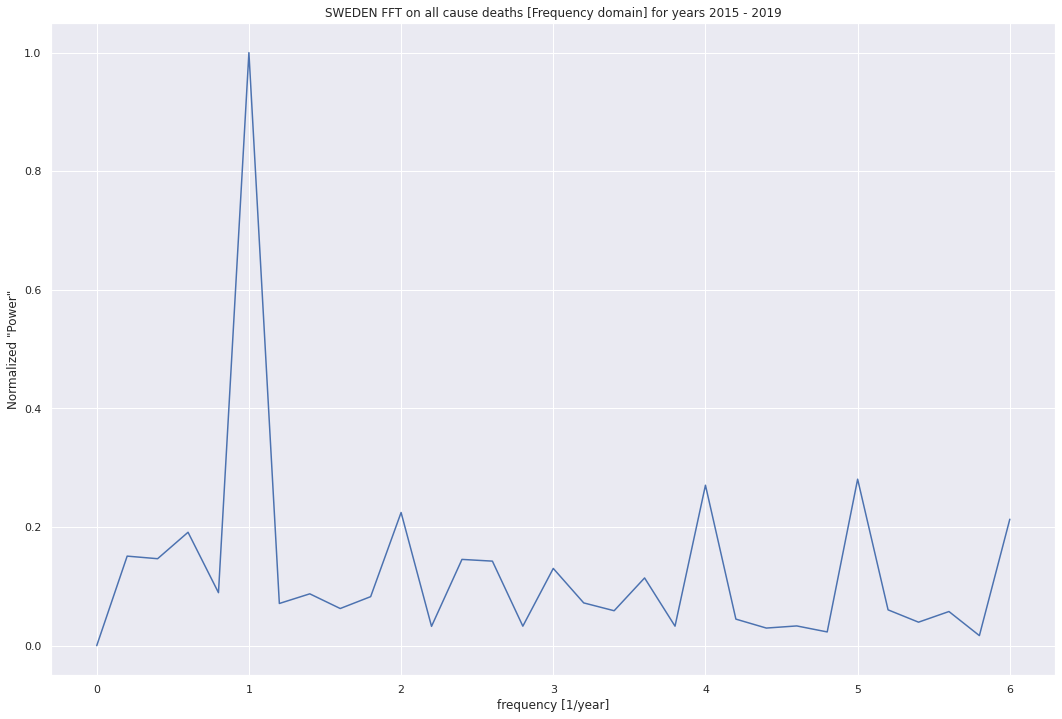

In [14]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN FFT on all cause deaths [Frequency domain] for years {} - {}'.format(start_year,end_year))
plt.xlabel('frequency [1/year]')
plt.ylabel('Normalized "Power"')
plt.plot(xf,np.abs(yf) / np.abs(yf).max())
yf_max = yf.argmax()
print (yf_max)
plt.savefig('fft_swe_deaths_periodicity_{}_{}.jpg'.format(start_year,end_year),format='jpg')

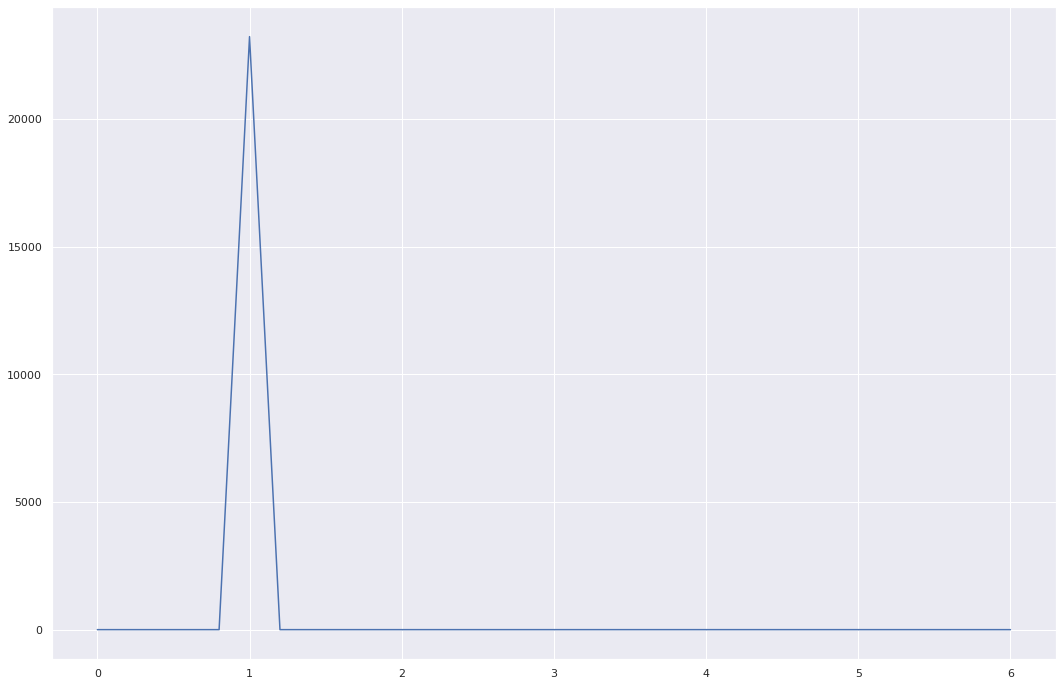

In [15]:
dominant_freq = np.zeros_like(yf)
dominant_freq[yf_max] = yf[yf_max]

plt.figure(figsize=(18,12))
plt.plot(xf,np.abs(dominant_freq))

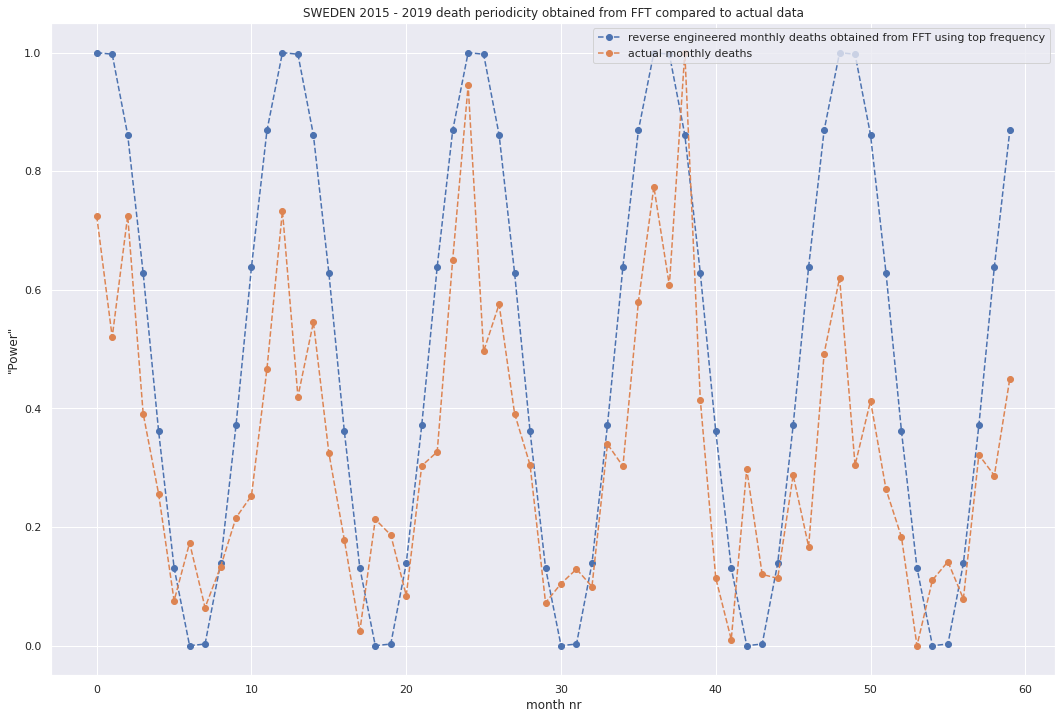

In [16]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

yf_filtered = irfft(dominant_freq)


plt.figure(figsize=(18,12))

ax = plt.gca()

title = 'SWEDEN {} - {} death periodicity obtained from FFT compared to actual data'.format(start_year,end_year)

ax.set_title(title)
ax.plot((yf_filtered / yf_filtered.max() + 1) / (yf_filtered / yf_filtered.max() +1).max(),'o--',
        label='reverse engineered monthly deaths obtained from FFT using top frequency')
ax.plot(NormalizeData(dead_df['dead'].values),'o--',label='actual monthly deaths')

ax.set_xlabel('month nr')
ax.set_ylabel('"Power"')

ax.legend(loc='upper right')
#ax.set_xticklabels(range(1,len(dead_df) + 1),rotation=90)


#for label in ax.xaxis.get_ticklabels()[0::12]:
        #label.set_visible(False)

In [ ]:
plt.plot(xf,yf)